## Final Project Submission


* Student name: Robert Fustero 
* Student pace: part time
* Scheduled project review 8/27/19
* Instructor name: Brandon Lewis


## Introduction

The goal of this project was to see if it were possible to guess the gender of an arrested person based on the arrest data alone.

Being able to profile the types of crime committed /criminals before they happen - gives law enforcement better insight to deal with their community.<br>
This is a proof of concept project showing how improving/stacking models can lead to better performance even with bad data

In [86]:
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from datetime import datetime
import pydotplus
from IPython.display import Image
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
from sklearn import pipeline as Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [64]:
import re
import string

In [65]:
df = pd.read_csv('arrest-data-from-2010-to-present.csv')
#column names had spaces - replaced with underscore
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_'))
df.columns = cols

## Time Conversion

I chunked up the time into different segments (night, late night, morning, afternoon etc) for better feature engineering

In [66]:
def Timeconv(time):
    label = []    
    for x in time:
        if x < 230:
            label.append('Night2')
        elif x < 530:
            label.append('Night3')
        elif x < 900:
            label.append('Morning1')
        elif x < 1200:
            label.append('Morning2')
        elif x < 1600:
            label.append('Afternoon')
        elif x < 2000:
            label.append('Dinner')
        else:
            label.append('Night1')
    return pd.Series(label)
df['Time_of_Day'] = Timeconv(df.Time)
#unclean datetime from origianl dataset
Dateformat = df['Arrest_Date'].str.slice(0,10)
dates = []
for x in Dateformat:
    dates.append(datetime.strptime(x, '%Y-%m-%d'))
df['Day_of_week'] = pd.Series(dates).dt.dayofweek
df['Month'] = pd.Series(dates).dt.month

In [67]:
df = df.dropna()

In [68]:
df = df.sample(n=10000,random_state=2)
#sampled from database

## Male Percentage Score

Calculating the percentage of crime commited by gender as a parameter

In [69]:
newdfm = df[['Sex_Code','Charge']][df.Sex_Code=='M']
newdff = df[['Sex_Code','Charge']][df.Sex_Code=='F']
malepercent = []
for x, y in zip(df.Charge, df.Charge):
        maletotal = list(newdfm.Charge).count(x)
        femaletotal = list(newdff.Charge).count(x)
        total = maletotal+femaletotal
        malepercent.append(maletotal/total)

In [70]:
df['Male_Percent'] = pd.Series(malepercent, index = df.index)

## Word Score

NLP is being used to come up with a word score by analyzing the words in 'Charge Description' and seeing which ones appear more frequently with each sex

In [71]:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist


In [72]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list = ["''", '""', '...', '``',':','/',"'s","is",'or','on','of','for','to','los','angeles',"in",
                  '4',',','$','(',')','-','any','by','from','>','<','a','less','only','code','hours','no','act']
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed=[]
    for token in tokens:
        if token.lower() not in stopwords_list:
            stopwords_removed.append(token.lower())
    return stopwords_removed   


In [73]:
fwordsraw = list(df[df['Sex_Code']=='F'].Charge_Description)
femalewords = list(map(process_article, fwordsraw))
female_vocab = set()
for comment in femalewords:
    female_vocab.update(comment)
fword_concat = []

for word in femalewords:
    fword_concat += word
#frequency distribution of most common words

fword_freqdist = FreqDist(fword_concat)
total_fword_count = sum(fword_freqdist.values())

#find most common words and normalize them
fword_top_200 = fword_freqdist.most_common(200)
fword_count = {}
for word in fword_top_200:
    fnormalized_frequency = word[1] / total_fword_count
    fword_count[word[0]] = fnormalized_frequency
    
    

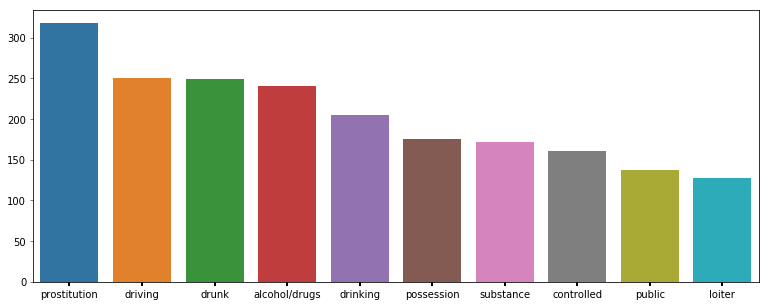

In [95]:
flist = []
fcount = []
for x in fword_top_200:
    flist.append(x[0])
    fcount.append(x[1])
rcParams['figure.figsize']= 13,5
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = .5
sns.barplot(x=flist[:10],y=fcount[:10]);

In [88]:
mwordsraw = list(df[df['Sex_Code']=='M'].Charge_Description)
malewords = list(map(process_article, mwordsraw))
male_vocab = set()
for comment in malewords:
    male_vocab.update(comment)
mword_concat = []
for word in malewords:
    mword_concat += word
#frequency distribution of most common words

mword_freqdist = FreqDist(mword_concat)
total_mword_count = sum(mword_freqdist.values())

#find most common words and normalize them
mword_top_200 = mword_freqdist.most_common(200)

mword_count = {}
for word in mword_top_200:
    mnormalized_frequency = word[1] / total_mword_count
    mword_count[word[0]] = mnormalized_frequency


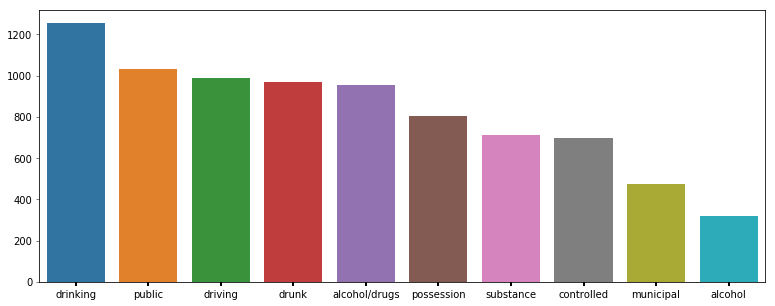

In [94]:
mlist = []
mcount = []
for x in mword_top_200:
    mlist.append(x[0])
    mcount.append(x[1])
rcParams['figure.figsize']= 13,5
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = .5
sns.barplot(x=mlist[:10],y=mcount[:10]);

In [57]:
#WORD SCORE IS CALCULATED BY SUBTRACTING THE NORMALIZED FREQUENCY OF THE MOST COMMON WORDS OF EACH GENDER

word_score =[]
for x in df.Charge_Description:
    charge_score = []
    for i in nltk.word_tokenize(x):
        if i.lower() in mword_count.keys():
            charge_score.append(mword_count[i.lower()])
        if i.lower() in fword_count.keys():
            charge_score.append(fword_count[i.lower()]*-1)
    word_score.append(sum(charge_score))
    
df['Word_Score'] = pd.Series(word_score,index = df.index)

## ZipCode Conversion

Instead of treating zipcodes like a categorical variable - I decided to append the taxable income per tax bracket per zipcoce.  It will be a way to rank how wealthy a neighborhood is that a crime was committed in.  It's just another parameter that will help my model make better decisions.

#### Issues:
None of the zipcodes in the database are valid.  I have to look up the zipcodes by importing in another database and then looking it up by longitude and latitude. <br>
I can then calculate the right zipcodes by finding the minimum distance between the different longitudes and latitudes. <br>
Once I have the right zipcodes - then I can look up those same zipcodes in another database I imported, and caluclate a score based on the average taxable income per tax bracket.

In [16]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list = ["''", '""', '...', '``',':','/','latitude','human_address','address','city','state','zip','longitude',
                 '{',"'latitude","'", "'",',', "'human_address", '}', "'longitude",'}',']','[']
def get_latlong(column):
    lat = []
    long = []
    Location = list(map(process_article, column))
    for x in range(len(Location)):
        lat.append(float(re.findall(r'\d+\.\d+', Location[x][0])[0]))
        long.append(float(re.findall(r'\d+\.\d+', Location[x][1])[0])*-1)
    return pd.Series(lat,index = df.index), pd.Series(long,index = df.index)
df['Latitude'], df['Longitude'] = get_latlong(df.Location)

In [18]:
dfzip = pd.read_csv('us-zip-code-latitude-and-longitude.csv')
zipdict = dict()
#Every parameter is in the index for some reason LOL
for x in dfzip.index:
    zipcode = x.split(';')[0]
    lat = float(x.split(';')[3])
    long = float(x.split(';')[4])
    if lat < 35 and lat > 33 and long > -119 and long < -117.8:
#storing relevant zipcodes based on the min max of lat/long of the dataset given
        zipdict[zipcode]=[lat,long]
def mindistzip(dct,x,y):
    distdict = {}
    for key, value in dct.items():  
        dist = np.hypot(float((value[0])-x),(float(value[1])-y))
#euclidean distance
        distdict[key] = dist
    distlist = list(distdict.values())
    mindist = min(distlist)
    for key, value in distdict.items():
        if value == mindist:
#returns zipcode with smallest distance
            return key
df.drop(['Zip_Codes'], axis=1, inplace=True)
Zip_Codes = []
for x,y in zip(df.Latitude,df.Longitude):
    try:
        Zip_Codes.append(mindistzip(zipdict,x,y))
    except:
        Zip_Codes.append('none')
df['Zip_Codes'] = pd.Series(Zip_Codes,index = df.index)

In [20]:
dfx = pd.read_excel('16zp05ca.xls')

In [21]:
zipincomedict = {}
for x,y,z in zip(dfx.iloc[13:,0],dfx.iloc[13:,91],dfx.iloc[13:,92]):
    if str(x) in list(df['Zip_Codes']):
        if y == 0:
            avginc = 0
        else:
            avginc = z/y
        try:
            zipincomedict[str(x)].append(avginc)
        except:
            zipincomedict[str(x)] = []
            zipincomedict[str(x)].append(avginc)
zipscoredict = {}
for key, value in zipincomedict.items():
    zipscoredict[key] = sum(value)
income_list = []
for x in df.Zip_Codes:
    try:
        income_list.append(zipscoredict[str(x)])
    except:
        income_list.append(np.median(list(zipscoredict.values())))
df['Income_Score'] = pd.Series(income_list,index = df.index)

In [22]:

rcParams['figure.figsize']= 13,10
rcParams['xtick.major.width'] = .5
rcParams['ytick.major.width'] = .5

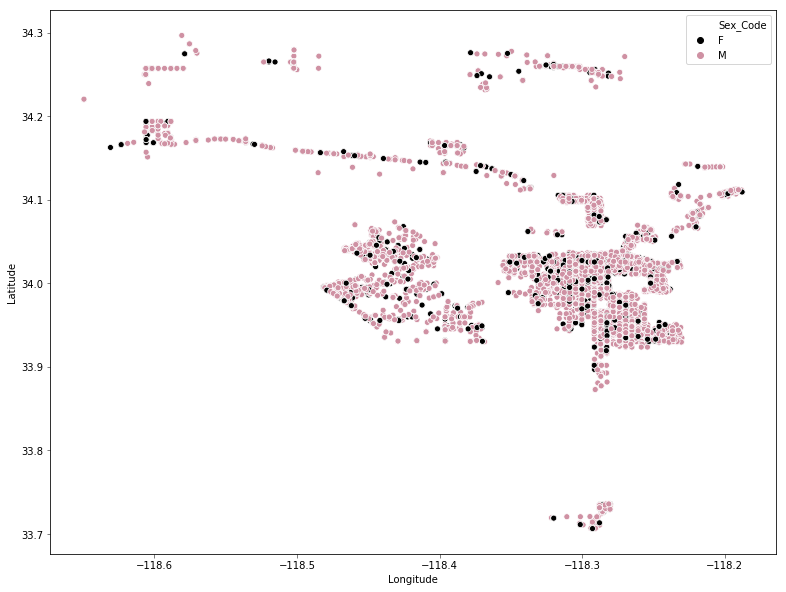

In [24]:
cmap = sns.cubehelix_palette(n_colors=2,dark=0, light=.65, as_cmap=False, reverse=True)

sns.scatterplot(x=df.Longitude,y=df.Latitude, hue=df.Sex_Code, palette=cmap,data=df);

## Drop unnecessary columns

In [25]:
df.drop(['Report_ID', 'Arrest_Date', 'Time', 'Area_Name',
       'Reporting_District', 'Charge_Group_Description', 
        'Charge_Description', 'Address', 'Cross_Street', 'Location',
        'Census_Tracts','Zip_Codes', 'Longitude','Latitude','Precinct_Boundaries',
       'LA_Specific_Plans', 'Council_Districts',
       'Neighborhood_Councils_(Certified)'], axis=1, inplace=True)

In [26]:
X = df.iloc[:,:].values
labelencoder_X = LabelEncoder()
df.Time_of_Day = labelencoder_X.fit_transform(X[:,9])
df.Sex_Code = labelencoder_X.fit_transform(X[:,2])
df.Descent_Code = labelencoder_X.fit_transform(X[:,3])
df.Charge_Group_Code = labelencoder_X.fit_transform(X[:,4])
df.Arrest_Type_Code = labelencoder_X.fit_transform(X[:,5])
df.Charge = labelencoder_X.fit_transform(X[:,6])

## Get Dummy Variables

In [27]:
df = pd.get_dummies(df, columns=['Area_ID', 'Descent_Code', 'Charge_Group_Code',
       'Arrest_Type_Code', 'Charge', 'Day_of_week', 'Month', 'Time_of_Day'])

## Set Target

In [28]:
target = df.Sex_Code
df.drop('Sex_Code', axis=1, inplace=True)

In [29]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    


## Principal component analysis

By applying demensionality reduction (with PCA) we can speed up the training with minimum accuracy loss

In [30]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=5)
pca_2 = PCA(n_components=10)
pca_3 = PCA(n_components=20)

principalComponents = pca_1.fit_transform(df)
principalComponents = pca_2.fit_transform(df)
principalComponents = pca_3.fit_transform(df)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))



0.9999492524401042
0.999958761734631
0.9999744954138129


## Applying PCA and Scaling

In [31]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df)
pd.DataFrame(data = X, columns = df.columns).head()
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)

df2 = pd.DataFrame(data = principalComponents)
df2.head()

/Users/robertfustero/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/robertfustero/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0,1,2,3,4
0,1.858908,2.079507,-1.358381,1.080038,-1.031170
1,-3.075749,-0.205627,-1.010948,0.202209,-1.311751
2,1.517030,-1.720345,-0.799348,0.771527,-0.687639
3,-0.415964,0.988212,-1.500810,-0.200173,2.663164
4,-0.393930,-0.222384,-1.176923,0.072076,-1.315166


In [32]:
df2.columns = df2.columns.astype(str)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df2, target, test_size=0.25)

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

## Data Pipeline

By using a data pipeline, I can optimize my hyper parameters easily and then compare the best version of each model

In [37]:
#classification model pipelines
pipelines = {
    'kneighborsclassifier': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'logisticregression': make_pipeline(StandardScaler(), LogisticRegression()),
    'randomforestclassifier': make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gradientboostingclassifier': make_pipeline(StandardScaler(), GradientBoostingClassifier())
}
#define hyperparameters for each model 
kneighborsclassifier_hyperparameters = {
    'kneighborsclassifier__n_neighbors': [5, 7, 9,12],
    'kneighborsclassifier__leaf_size':[1,2,3,5],
    'kneighborsclassifier__weights': ['uniform','distance'],
    'kneighborsclassifier__algorithm':['auto', 'ball_tree','kd_tree','brute']
}
logisticregression_hyperparameters = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__solver': ['sag','saga']
}
randomforestclassifier_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200,300], 
    'randomforestclassifier__max_features': ['auto', 'sqrt',0.33]
}
gradientboostingclassifier_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200], 
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2, 1],
    'gradientboostingclassifier__max_depth': [1, 3, 5, 7]
}
#set hyperparameter dictionary
hyperparameters = {
    'kneighborsclassifier': kneighborsclassifier_hyperparameters,
    'logisticregression': logisticregression_hyperparameters,
    'randomforestclassifier': randomforestclassifier_hyperparameters,
    'gradientboostingclassifier': gradientboostingclassifier_hyperparameters
}

In [38]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1, scoring='roc_auc')
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    confusion_matrix(y_hat, y_test)
    fitted_models[name] = model
    print(name, 'has been fitted.')

for name, model in fitted_models.items(): 
    print(name, model.best_score_)
    y_hat = model.predict(X_test)
    print(name, roc_auc_score(y_test,y_hat))
    confusion_matrix(y_hat, y_test)

kneighborsclassifier has been fitted.
logisticregression has been fitted.
randomforestclassifier has been fitted.
gradientboostingclassifier has been fitted.
kneighborsclassifier 0.6784602432620188
kneighborsclassifier 0.5973378362333944
logisticregression 0.7156518974672962
logisticregression 0.5718210361067504
randomforestclassifier 0.6917436917896124
randomforestclassifier 0.5962066145139375
gradientboostingclassifier 0.7294581356191643
gradientboostingclassifier 0.5825637947486687


## Voting Classifier
Voting classifiers work exactly how the name describes.  Each model classifies the information to the target variable and then each 'vote' (prediction the ML model made) is weighed together to get the final result.

In [39]:
v_clf = VotingClassifier(estimators=[('rf',fitted_models['randomforestclassifier']),('gb',fitted_models['gradientboostingclassifier']),('lr', fitted_models['logisticregression']),('knn',fitted_models['kneighborsclassifier'])])
v_clf.fit(X_train, y_train)

v_train_preds = v_clf.predict(X_train)
v_test_preds = v_clf.predict(X_test)
print("Training Metrics")
display_acc_and_f1_score(y_train, v_train_preds, model_name='Voting')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, v_test_preds, model_name='Voting')
print("")
print("Roc Auc Score:", roc_auc_score(v_test_preds,y_test))
print("Cross Validation Score:", cross_val_score(v_clf,df2,target,cv=5).mean())

Training Metrics
Model: Voting
Accuracy: 0.8572
F1-Score: 0.9186355693990732

Testing Metrics
Model: Voting
Accuracy: 0.8468
F1-Score: 0.9136804146946136

Roc Auc Score: 0.7979201623016824
Cross Validation Score: 0.8389011178252794


In [42]:
print(classification_report(y_test,v_test_preds))

              precision    recall  f1-score   support

           0       0.74      0.20      0.32       442
           1       0.85      0.98      0.91      2058

   micro avg       0.85      0.85      0.85      2500
   macro avg       0.80      0.59      0.62      2500
weighted avg       0.83      0.85      0.81      2500



## Conclusion:
Similar accuracy and f1 score for testing and training data mean my model fits the data pretty well and it's not over fitting. <br>
With a ROC AUC score near 80 and a Cross Val score near 84, my model performs fairly well.<br>
Combining models gave me an ROC AUC score 10 points higher than any model performed individually.<br>
Still, despite adding parameters and tuning parameters is still not perfect at identifying men vs women.<br>
For crimes where men and women commit them near the same rates per gender, it's difficult to guess sex based on how the crime happened alone.<br>


## Future Work:
Using more information about crime statistics and time series analysis - could help predict what types of crime occur when as well as being able to predict gender better.